<a href="https://colab.research.google.com/github/sda96/repo/blob/master/%EB%B2%84%EC%8A%A4%EB%85%B8%EC%84%A0%EC%8B%9C%EA%B0%81%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install config
!pip install tinify
!pip install geopandas
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy
!pip install geoplot
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import sys
import urllib.request
import datetime
import time
import json
from config import *
import requests
import tinify
import shutil

from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import urllib.request
import io
import binascii
try:
    from urllib.request import Request, urlopen  # Python 3
except ImportError:
    from urllib2 import Request, urlopen  # Python 2

from io import BytesIO 
import numpy as np
%matplotlib inline
import matplotlib as plt

import geopandas as gpd
import descartes
import plotly.graph_objects as go
from google.colab import drive
import geoplot 
drive.mount('/gdrives')

In [ ]:
os.chdir('/gdrives/My Drive')
station = pd.read_csv("./PJT001_stations_table.csv")
emd = pd.read_csv("./PJT001_sk_emd_od.csv")
route  = pd.read_csv("./PJT001_routestationinfo.csv")
chain = pd.read_csv("./PJT001_TripChain.csv")

In [ ]:
a = "./PJT001_tl_scco_emd.geojson"
df = gpd.read_file(a)
b = "./PJT001_moc_link_2018.geojson"
adf = gpd.read_file(b)
c = "./PJT001_h_100m_cell_pop.geojson"
bdf = gpd.read_file(c)

In [ ]:
route

,seq,pr_station_id,bus_line_no,bus_line_no_seq,station_nm,station_id,mobile_no
0,65286,228000018,10-4,1,용인터미널,228001552,47634.0
1,65287,228000018,10-4,2,용인터미널(경유),277102443,NaN
2,65288,228000018,10-4,3,포브스병원,228000443,29439.0
3,65289,228000018,10-4,4,제일교회,228000665,29881.0
4,65290,228000018,10-4,5,라이프아파트,228000664,29457.0
...,...,...,...,...,...,...,...
37826,191750,241491011,38-1,63,신일해피트리후문,233002733,NaN
37827,191751,241491011,38-1,64,기배동행정복지센터,233002726,NaN
37828,191752,241491011,38-1,65,기안1통입구,233002959,NaN
37829,191753,241491011,38-1,66,배양2리,233002717,55455.0


In [ ]:
station

,표준정류장ID,시군명,정류소명,정류소영문명,정류소번호,중앙차로여부,관할관청,위치,WGS84위도,WGS84경도,모바일정류장ID,이비카드정류장ID
0,228003422,용인시,손골마을회관.국제학교,"Songol Community Center,",56443.0,노변정류장,경기도 용인시,NaN,37.342517,127.066817,56443.0,NaN
1,228003423,용인시,풀잎사랑,Pulipsarang,56444.0,노변정류장,경기도 용인시,NaN,37.341800,127.068983,56444.0,NaN
2,228003424,용인시,풀잎사랑,Pulipsarang,56445.0,노변정류장,경기도 용인시,NaN,37.341817,127.069083,56445.0,NaN
3,228003425,용인시,대성공정,Daesung Process,56446.0,노변정류장,경기도 용인시,NaN,37.339350,127.073067,56446.0,NaN
4,228003426,용인시,대성공정,Daesung Process,56447.0,노변정류장,경기도 용인시,NaN,37.339183,127.073400,56447.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
38504,228003381,용인시,현대빌리지,Hyundai Village,56402.0,노변정류장,경기도 용인시,NaN,37.326433,127.071317,56402.0,NaN
38505,228003382,용인시,현대빌리지,Hyundai Village,56403.0,노변정류장,경기도 용인시,NaN,37.326450,127.071100,56403.0,NaN
38506,236001229,포천시,평강식물원,Pyunggang Botanical Garden,40691.0,노변정류장,경기도 포천시,경기도 포천시 영북면,38.050650,127.306617,40691.0,NaN
38507,236001230,포천시,양문1리.영중면사무소,"Yangmun 1-ri, Yeongjung-myeon Office",40699.0,노변정류장,경기도 포천시,NaN,38.005517,127.245667,40699.0,NaN


In [ ]:
route_station = pd.merge(route,station,left_on="station_id",right_on="표준정류장ID")
route_station

,seq,pr_station_id,bus_line_no,bus_line_no_seq,station_nm,station_id,mobile_no,표준정류장ID,시군명,정류소명,정류소영문명,정류소번호,중앙차로여부,관할관청,위치,WGS84위도,WGS84경도,모바일정류장ID,이비카드정류장ID
0,65286,228000018,10-4,1,용인터미널,228001552,47634.0,228001552,용인시,용인터미널,Yongin Terminal,47634.0,노변정류장,경기도 용인시,경기도 용인시 처인구 김량장동,37.232783,127.2101,[None None None None None None None None None ...,4176783.0
1,65286,228000018,10-4,1,용인터미널,228001552,47634.0,228001552,용인시,용인터미널,Yongin Terminal,47634.0,노변정류장,경기도 용인시,경기도 용인시 처인구 김량장동,37.232783,127.2101,[None None None None None None None None None ...,9176783.0
2,65476,228000020,7,1,용인터미널,228001552,47634.0,228001552,용인시,용인터미널,Yongin Terminal,47634.0,노변정류장,경기도 용인시,경기도 용인시 처인구 김량장동,37.232783,127.2101,[None None None None None None None None None ...,4176783.0
3,65476,228000020,7,1,용인터미널,228001552,47634.0,228001552,용인시,용인터미널,Yongin Terminal,47634.0,노변정류장,경기도 용인시,경기도 용인시 처인구 김량장동,37.232783,127.2101,[None None None None None None None None None ...,9176783.0
4,65528,228000021,8,1,용인터미널,228001552,47634.0,228001552,용인시,용인터미널,Yongin Terminal,47634.0,노변정류장,경기도 용인시,경기도 용인시 처인구 김량장동,37.232783,127.2101,[None None None None None None None None None ...,4176783.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39452,191612,241491008,38,64,배양1동,233532650,NaN,233532650,화성시,배양1동,NaN,NaN,NaN,NaN,NaN,37.226783,126.9977,NaN,NaN
39453,191688,241491011,38-1,1,배양1동,233532650,NaN,233532650,화성시,배양1동,NaN,NaN,NaN,NaN,NaN,37.226783,126.9977,NaN,NaN
39454,191754,241491011,38-1,67,배양1동,233532650,NaN,233532650,화성시,배양1동,NaN,NaN,NaN,NaN,NaN,37.226783,126.9977,NaN,NaN
39455,191680,241491010,100,11,신창2차비바패밀리,233002346,NaN,233002346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
route_station = route_station[["bus_line_no","정류소명","관할관청","WGS84위도","WGS84경도","이비카드정류장ID"]]
route_station = route_station.loc[route_station['관할관청']=="경기도 화성시",:]
route_station = gpd.GeoDataFrame(route_station, geometry=gpd.points_from_xy(route_station.WGS84경도, route_station.WGS84위도))
route_station

,bus_line_no,정류소명,관할관청,WGS84위도,WGS84경도,이비카드정류장ID,geometry
1575,24,한원IC,경기도 화성시,37.152733,127.122883,4170725.0,POINT (127.12288 37.15273)
1576,24,장지리,경기도 화성시,37.155117,127.117900,4170397.0,POINT (127.11790 37.15512)
1577,19-2,장지리,경기도 화성시,37.155117,127.117900,4170397.0,POINT (127.11790 37.15512)
1578,39,장지리,경기도 화성시,37.155117,127.117900,4170397.0,POINT (127.11790 37.15512)
1579,24,장지리,경기도 화성시,37.155867,127.115017,4170396.0,POINT (127.11502 37.15587)
...,...,...,...,...,...,...,...
39446,38,중외제약사거리,경기도 화성시,37.202167,127.001983,4199720.0,POINT (127.00198 37.20217)
39447,35-2,융건릉.용주사입구,경기도 화성시,37.206933,126.989250,4199718.0,POINT (126.98925 37.20693)
39448,38,융건릉.용주사입구,경기도 화성시,37.206933,126.989250,4199718.0,POINT (126.98925 37.20693)
39449,35-2,와우2리,경기도 화성시,37.215583,126.976267,NaN,POINT (126.97627 37.21558)


In [ ]:
  from shapely.geometry import Point, LineString, shape
  route_station2 = route_station.groupby(['bus_line_no'])['geometry'].apply(lambda x: LineString(x.tolist()))
  route_station2 = gpd.GeoDataFrame(route_station2, geometry='geometry')
  route_station2

,geometry
bus_line_no,
1,"LINESTRING (126.81580 37.08223, 126.81580 37.0..."
1-1,"LINESTRING (126.81580 37.08223, 126.81580 37.0..."
10,"LINESTRING (126.90548 37.13803, 126.90112 37.1..."
10-1,"LINESTRING (126.90548 37.13803, 126.90942 37.1..."
10-2,"LINESTRING (126.90548 37.13803, 126.90942 37.1..."
...,...
공영4(돌내독지2),"LINESTRING (126.73265 37.21270, 126.73663 37.2..."
공영4(마산.고포),"LINESTRING (126.73265 37.21270, 126.73663 37.2..."
공영4(삼존2.3리),"LINESTRING (126.73898 37.21338, 126.74492 37.2..."


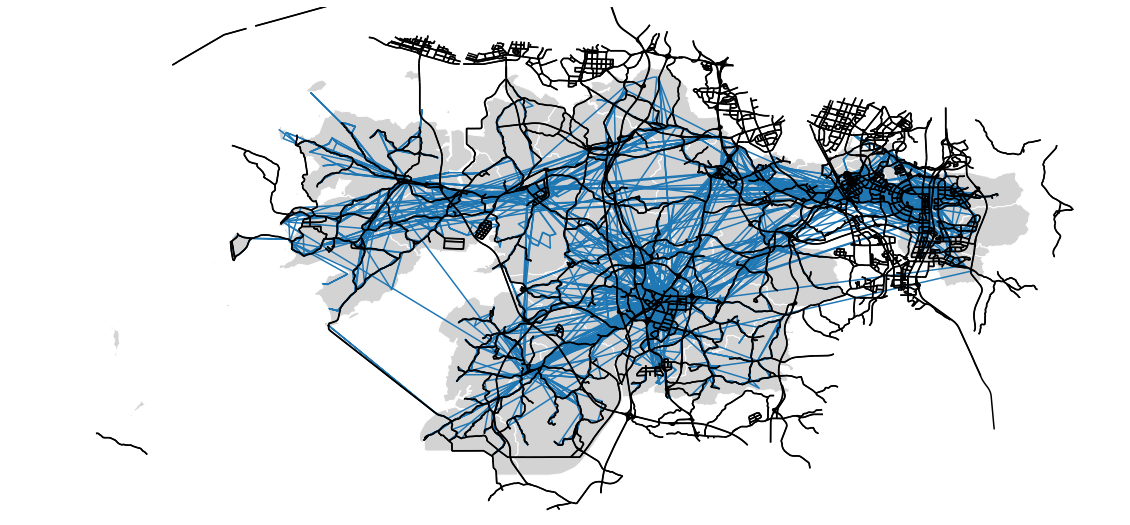

In [ ]:
ax = geoplot.polyplot(
    df,
    edgecolor='white', facecolor='lightgray',
    figsize=(20, 10)
)
route_station2.iloc[:,:].plot(ax=ax)
adf.plot(ax=ax, color='black', markersize=0.01)